In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader.data as web
from scipy import optimize 
from datetime import datetime
from dateutil.relativedelta import relativedelta
%matplotlib inline

try:
  import pandas_datareader.data as web
except:
  !pip install pip pandas-datareader
  import pandas_datareader.data as web

In [ ]:
class Asset():
  def __init__(self, ticker, name, start, end):
    self.ticker = ticker
    self.name = name
    
    self.start = start
    self.end = end

    # 데이터 불러오기
    self.data = web.get_data_yahoo(self.ticker, self.start, self.end)
    self.date = self.data.index

    self.ratio = 0
    self.leverage = 0
    self.price = None
    self.change = None

  def put_ratio_leverage(self, ratio, leverage):
    self.ratio = ratio
    self.leverage = leverage

  def put_price_change(self):
    self.price = self.data['Adj Close']
    self.change = np.multiply(self.price.pct_change().to_list(), [100 * self.leverage])

  def get_date(self):
    return self.date

  def get_change(self):
    return self.change

  def get_name(self):
    return self.name

In [ ]:
#class Stock takes array of closing prices at the beginning and at the end of the year
#and calculates geometric return and standard deviation
#to simplify the calculation let's assume that there are no dividends
class Stock:
    def __init__(self, prices):
        self.prices = prices

    def annual_returns(self):
        returns = []
        for i in range(0, len(self.prices)-1):
            returns.append((self.prices[i+1]-self.prices[i])/self.prices[i])
        return(returns)
            
    def geometric_return(self, returns):
        return(np.prod([x+1 for x in returns])**(1/len(returns))-1)
    
    def standard_deviation(self, returns):
        mean = sum(returns)/len(returns)
        return(np.sqrt(sum([(x-mean)**2 for x in returns])/len(returns)))

In [ ]:
class Portfolio():
  def __init__(self, name, assets, ratios, leverages, initial_balance, rebalancing_interval):
    self.name = name
    
    # list of class asset elements
    self.assets = assets

    # Assert all the dates for assets are equal and set portfolio start, end dates
    dates = [each.get_date() for each in self.assets]
    lendates = [len(each) for each in dates]
    assert len(set(lendates)) == 1
    self.date = dates[0]

    self.ratios = [each / sum(ratios) for each in ratios]
    self.leverages = leverages

    for i in range(len(self.assets)):
      self.assets[i].put_ratio_leverage(self.ratios[i], self.leverages[i])
      self.assets[i].put_price_change()

    self.initial_balance = initial_balance  
    self.rebalancing_interval = rebalancing_interval

    self.backtest_df = None
    self.backtest_result_df = None
    self.summary = None

  def backtest(self):
    # 첫 거래일
    balances = []
    for i in range(len(self.assets)):
      balance = [self.initial_balance * self.ratios[i]]
      balances.append(balance)
    
    total_balance = [self.initial_balance]
    next_rebalancing = [self.date[0] + relativedelta(months=self.rebalancing_interval)]

    # 이후 거래일
    for i in range(1, len(self.date)):
      total_balance_tmp = 0

      if self.date[i] >= next_rebalancing[i-1]: # 리밸런싱하는 날
        # 다음 리밸런싱 날짜 추가
        next_rebalancing.append(next_rebalancing[i-1] + relativedelta(months=self.rebalancing_interval))
        for j in range(len(self.assets)):
          balance = total_balance[i-1] * self.ratios[j] * (1 + self.assets[j].get_change()[i] / 100)
          balances[j].append(balance)
          total_balance_tmp += balances[j][i]
      else:
        # 이전 리밸런싱 날짜랑 동일하게
        next_rebalancing.append(next_rebalancing[i-1])
        for j in range(len(self.assets)):
          try:
            balances[j].append(balances[j][i-1] * (1 + self.assets[j].get_change()[i] / 100))
          except:
            balances[j].append(balances[j][i-1])
          total_balance_tmp += balances[j][i]

      total_balance.append(total_balance_tmp)

    df = pd.DataFrame()
    df['Date'] = self.date
    df.set_index('Date', inplace=True)
    df['Total'] = total_balance

    for i in range(len(self.assets)):
      df[self.assets[i].get_name()] = balances[i]
    
    print('Portfolio Backtest Complete')
    self.backtest_df = df

    return df

  def balance_result(self, balance):
    change = [0]
    cum_return = [0]
    prev_high = [0]
    prev_high_tmp = 0
    drawdown = [0]
    mdd = [0]
    mdd_tmp = 0
    CAGR = [0]
    stdev = [0]
    sharpe = [0]

    time_period = (self.date[-1] - self.date[0]).days / 365

    for i in range(1, len(self.date)):
      change.append((balance[i] / balance[i-1] - 1) * 100)
      
      cum_return.append((balance[i] / balance[0] - 1) * 100)

      if prev_high_tmp < cum_return[i]:
        prev_high_tmp = cum_return[i]
      else:
        prev_high_tmp = prev_high_tmp
      prev_high.append(prev_high_tmp)

      CAGR.append(((balance[i] / balance[0]) ** (1 / float(time_period)) - 1) * 100)

      drawdown.append(((cum_return[i] + 100) / (prev_high[i] + 100) - 1) * 100)

      if mdd_tmp > drawdown[i]:
        mdd_tmp = drawdown[i]
      else:
        mdd_tmp = mdd_tmp
      mdd.append(mdd_tmp)

      stdev.append(np.std(change))
      if stdev[i] != 0:
        sharpe.append(np.sqrt(252) * np.mean(change) / np.std(change))
      else:
        sharpe.append(0)

    return change, cum_return, prev_high, CAGR, drawdown, mdd, stdev, sharpe

  def backtest_result(self):
    df = pd.DataFrame()
    df['Date'] = self.date
    df.set_index('Date', inplace=True)
    label = ['Change', 'Cum. Return', 'Prev. High', 'CAGR', 'Drawdown', 'MDD', 'St. Dev', 'Sharpe']

    result = dict()
    for i in self.backtest_df.columns:
      result[i] = self.balance_result(self.backtest_df[i].to_list())
      df[f'{i} Balance'] = self.backtest_df[i].to_list()
      print(f'{i} Complete')
    for j in range(len(label)):
      for i in self.backtest_df.columns:
        df[f'{i} {label[j]}'] = result[i][j]

    self.backtest_result_df = df

    return df
  
  def periodic_result(self, mode):
    df = pd.DataFrame()

    for label in self.backtest_df.columns:
      return_points = []
      returns = []
      start_balance = []
      end_balance = []
      start = self.backtest_df[label].to_list()[0]
      
      if mode == 'annual':
        for i in range(1, len(self.date)):
          if self.date[i].year != self.date[i-1].year:
            return_points.append(self.date[i-1].year)
            returns.append((self.backtest_df[label].to_list()[i-1] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
            start = self.backtest_df[label].to_list()[i]
          elif self.date[i] == self.date[-1]: # 마지막 거래일
            return_points.append(self.date[i].year)
            returns.append((self.backtest_df[label].to_list()[i] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
        df[f'{label} {mode.capitalize()} Return'] = returns
        
      elif mode == 'monthly':
        for i in range(1, len(self.date)):
          if self.date[i].month != self.date[i-1].month:
            return_points.append(self.date[i-1].strftime('%Y-%m'))
            returns.append((self.backtest_df[label].to_list()[i-1] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
            start = self.backtest_df[label].to_list()[i]
          elif self.date[i] == self.date[-1]: # 마지막 거래일
            return_points.append(self.date[i].strftime('%Y-%m'))
            returns.append((self.backtest_df[label].to_list()[i] / start - 1) * 100)
            start_balance.append(start)
            end_balance.append(self.backtest_df[label].to_list()[i-1])
        df[f'{label} {mode.capitalize()} Return'] = returns

    df[f'Return {mode.capitalize()}'] = return_points
    df.set_index(f'Return {mode.capitalize()}', inplace=True)

    print(f'{mode.capitalize()} Result Complete')

    return df

  def get_name(self):
    return self.name

  def get_date(self):
    return self.date

  def get_backtest_result(self):
    return self.backtest_result_df

  def get_summary(self):
    # columns=['Detail', 'Initial Balance', 'Final Balance', 'CAGR', 'MDD', 'St. Dev', 'Sharpe Ratio']
    
    detail = ''
    for i in range(len(self.assets)):
      name = self.assets[i].get_name()
      percentage = int(self.ratios[i] * 100)

      detail += f'{name} ({percentage}%, {self.leverages[i]}x) '

    self.summary = [detail, self.backtest_result_df['Total Balance'][0], self.backtest_result_df['Total Balance'][-1],
                    str(round(self.backtest_result_df['Total CAGR'][-1], 2))+'%', str(round(self.backtest_result_df['Total MDD'][-1], 2))+'%',
                    round(self.backtest_result_df['Total St. Dev'][-1], 2), round(self.backtest_result_df['Total Sharpe'][-1], 2)]
    
    return self.summary

In [ ]:
class Visualize():
  def __init__(self, portfolios):
    self.portfolios = portfolios

     # Assert all the dates for assets are equal and set portfolio start, end dates
    dates = [each.get_date() for each in self.portfolios]
    lendates = [len(each) for each in dates]
    assert len(set(lendates)) == 1
    self.date = dates[0]

  def line_plot(self, result, title, return_type):
    for i in range(len(self.portfolios)):
      plt.plot(self.date, self.portfolios[i].get_backtest_result().loc[:, f'Total {result}'], label=self.portfolios[i].get_name())
    
    plt.title(title)
    plt.legend(loc='best')
    plt.yscale(return_type)
    plt.show()

  def bar_plot(self, title, period):
    for i in range(len(self.portfolios)):
      if period == 'annual':
        result = self.portfolios[i].periodic_result('annual')
        plt.bar(result.index, result.loc[:, 'Total Annual Return'], label=self.portfolios[i].get_name())
      elif period == 'monthly':
        result = self.portfolios[i].periodic_result('monthly')
        plt.bar(result.index, result.loc[:, 'Total Monthly Return'], label=self.portfolios[i].get_name())
    
    plt.title(title)
    plt.legend(loc='best')
    plt.show()

In [ ]:
#class portfolio takes matrix of returns for every stock, and array of their weights
class GMVPortfolio:
    def __init__(self, returns):
        self.returns = returns
    
    def portfolio_return(self, weights):
        geo_returns = []
        for i in range(0, len(self.returns)):        
            geo_returns.append(np.prod([x+1 for x in self.returns[i]])**(1/len(self.returns[i]))-1)
        return(sum([a*b for a,b in zip(weights, geo_returns)]))
        #return(geo_returns)

    def portfolio_volatility(self, weights):
        sd_values = []
        for i in self.returns:
            mean = sum(i)/len(i)
            sd_values.append(np.sqrt(sum([(x-mean)**2 for x in i])/len(i)))
        weighted_average = [a*b for a,b in zip(weights, sd_values)]
        corr = np.corrcoef(self.returns)
        values = []
        for j in range(0, len(weighted_average)):
            values.append(sum([weighted_average[j]*weighted_average[x]*corr[j,x] for x in range(0,len(weighted_average))]))
        return(np.sqrt(sum(values)))
        #return(values)

    def optimal_portfolio(self, desired_return):
        bounds = ((0.0, 1.0),) * len(self.returns)
        init = list(np.random.dirichlet(np.ones(len(self.returns)), size= 1)[0])
        optimal_weights = optimize.minimize(self.portfolio_volatility, init, method='SLSQP',
            constraints=({'type': 'eq', 'fun': lambda inputs: 1.0 - np.sum(inputs)},
            {'type': 'eq', 'fun': lambda inputs: desired_return - self.portfolio_return(weights=inputs)}), bounds = bounds)
        return optimal_weights.x

In [85]:
stocks_to_portfolio = ['AMZN', 'AAPL', 'SBUX', 'SO', 'INTC', 'CSCO', 'MET']
return_matrix = []
stock_char = []
asset_list = []
for i in stocks_to_portfolio:
    asset = Asset(i, "Asset " + str(i), '2016-01-01', '2020-10-31')
    asset_list.append(asset)
    prices = list(asset.data['Adj Close'])
    stock = Stock(prices)
    stock_char.append([i, stock.geometric_return(stock.annual_returns()), stock.standard_deviation(stock.annual_returns())])
    return_matrix.append(stock.annual_returns())
stock_char

[['AMZN', 0.0012850285368668501, 0.019119581238019052],
 ['AAPL', 0.0012358545425483758, 0.01905339474893885],
 ['SBUX', 0.00040387385517171026, 0.017108280065907533],
 ['SO', 0.0003460047023939872, 0.015614670702163281],
 ['INTC', 0.00032212934683184535, 0.021011689165867976],
 ['CSCO', 0.00037845540337655414, 0.017325434836706823],
 ['MET', 5.433977797952849e-05, 0.021843210366789413]]

## GMV Portfolio

In [109]:
plot_data = []
n = 0
while n < 5000:
    weight = list(np.random.dirichlet(np.ones(len(return_matrix)), size= 1)[0])
    port = GMVPortfolio(return_matrix)
    plot_data.append([weight, port.portfolio_return(weight), port.portfolio_volatility(weight)])
    n += 1

rets = [ret[1] for ret in plot_data]
vols = [vol[2] for vol in plot_data]
stock_rets = [ret[1] for ret in stock_char]
stock_vols = [vol[2] for vol in stock_char]

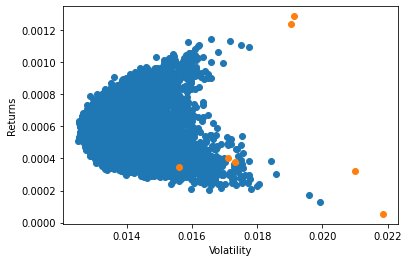

In [106]:
plt.scatter(vols, rets)
plt.scatter(stock_vols, stock_rets)
plt.xlabel("Volatility")
plt.ylabel("Returns")
plt.show()

In [ ]:
port = GMVPortfolio(return_matrix)
weights = port.optimal_portfolio(0.1)
# rounded_weights = [round(num, 3) for num in weights]

gmv_portfolio = Portfolio('GMV', asset_list, weights, [1, 1, 1, 1, 1, 1, 1], 1000, 12)
gmv_backtest_df = gmv_portfolio.backtest()
backtest_result_df = gmv_portfolio.backtest_result()
gmv_annual_return_df = gmv_portfolio.periodic_result('annual')
gmv_monthly_return_df = gmv_portfolio.periodic_result('monthly')
gmv_summary = gmv_portfolio.get_summary()

Portfolio Backtest Complete
Total Complete
Asset AMZN Complete
Asset AAPL Complete
Asset SBUX Complete
Asset SO Complete
Asset INTC Complete
Asset CSCO Complete
Asset MET Complete
Annual Result Complete
Monthly Result Complete


In [ ]:
gmv_summary

['Asset AMZN (99%, 1x) Asset AAPL (0%, 1x) Asset SBUX (0%, 1x) Asset SO (0%, 1x) Asset INTC (0%, 1x) Asset CSCO (0%, 1x) Asset MET (0%, 1x) ',
 1000.0,
 4766.401276160135,
 '38.22%',
 '-34.1%',
 1.91,
 1.22]

## 60/40 Portfolio

In [ ]:
asset1 = Asset('^IXIC', 'Asset 1', '2016-01-01', '2020-10-31')
asset2 = Asset('VUSTX', 'Asset 2', '2016-01-01', '2020-10-31')

sixty_forty_portfolio = Portfolio('60/40', [asset1, asset2], [6, 4], [1, 1], 1000, 3)
sixty_forty_backtest_df = sixty_forty_portfolio.backtest()
sixty_forty_backtest_result_df = sixty_forty_portfolio.backtest_result()
sixty_forty_annual_return_df = sixty_forty_portfolio.periodic_result('annual')
sixty_forty_monthly_return_df = sixty_forty_portfolio.periodic_result('monthly')
sixty_forty_summary = sixty_forty_portfolio.get_summary()

Portfolio Backtest Complete
Total Complete
Asset 1 Complete
Asset 2 Complete
Annual Result Complete
Monthly Result Complete


In [ ]:
sixty_forty_summary

['Asset 1 (60%, 1x) Asset 2 (40%, 1x) ',
 1000.0,
 1990.5192298202078,
 '15.34%',
 '-17.27%',
 0.73,
 1.29]

## All Weather Portfolio

In [ ]:
asset3 = Asset('VTI', 'Asset 3', '2016-01-01', '2020-10-31')
asset4 = Asset('EDV', 'Asset 4', '2016-01-01', '2020-10-31')
asset5 = Asset('IEI', 'Asset 5', '2016-01-01', '2020-10-31')
asset6 = Asset('GLD', 'Asset 6', '2016-01-01', '2020-10-31')
asset7 = Asset('GSG', 'Asset 7', '2016-01-01', '2020-10-31')

awf_portfolio = Portfolio('All Weather', [asset3, asset4, asset5, asset6, asset7], [3, 4, 1.5, 0.75, 0.75], [1, 1, 1, 1, 1], 1000, 12)
awf_backtest_df = awf_portfolio.backtest()
awf_backtest_result_df = awf_portfolio.backtest_result()
awf_annual_return_df = awf_portfolio.periodic_result('annual')
awf_monthly_return_df = awf_portfolio.periodic_result('monthly')
awf_summary = awf_portfolio.get_summary()

Portfolio Backtest Complete
Total Complete
Asset 3 Complete
Asset 4 Complete
Asset 5 Complete
Asset 6 Complete
Asset 7 Complete
Annual Result Complete
Monthly Result Complete


In [ ]:
awf_summary

['Asset 3 (30%, 1x) Asset 4 (40%, 1x) Asset 5 (15%, 1x) Asset 6 (7%, 1x) Asset 7 (7%, 1x) ',
 1000.0,
 1526.4247904162778,
 '9.16%',
 '-14.58%',
 0.52,
 1.1]

## Visualization

In [ ]:
aw_64 = Visualize([gmv_portfolio, sixty_forty_portfolio, awf_portfolio])

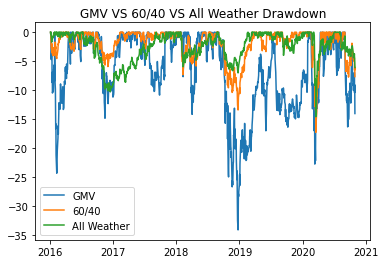

In [ ]:
aw_64.line_plot('Drawdown', 'GMV VS 60/40 VS All Weather Drawdown', 'linear')

Monthly Result Complete
Monthly Result Complete
Monthly Result Complete


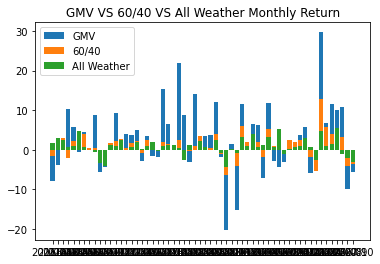

In [ ]:
aw_64.bar_plot('GMV VS 60/40 VS All Weather Monthly Return', 'monthly')